# COVID Project

For this research project, I will be conducting an analysis of COVID-19 sequences that have been sourced from the GISAID database. Specifically, my focus will be on data that pertains to the former Soviet Union countries. All of the necessary data has been obtained from GISAID, and I have implemented several filters such as geography, completeness, low coverage exclusion, and collection date completeness to ensure the quality and relevance of the data being used.

## All imports

In [24]:
# general modules
import pandas as pd
import re
import matplotlib.pyplot as plt
import glob
import os

# bioinformatics
from Bio import SeqIO
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor


# Distribution of patients, global

Below is the distribution of submissions by every country (global). 

In [2]:
df_submissions_raw = pd.read_excel("Data/gisaid_monthly_submissions_global_2023-03-28.xlsx")

df_submissions = df_submissions_raw[["Unnamed: 0", "country_total"]].copy()
df_submissions.rename(columns={"Unnamed: 0": "country", "country_total": "total"}, inplace=True)
df_submissions

,country,total
0,Afghanistan,125
1,Albania,1371
2,Algeria,797
3,American Samoa,121
4,Andorra,393
...,...,...
218,Vietnam,8692
219,Wallis and Futuna Islands,10
220,Zambia,2309
221,Zimbabwe,1010


There is no information comming from Tajikistan and Turkmenistan. Note, however, that number of actual records are lower if additional filters are used, like "low coverage excluded".

In [3]:
soviet_countries = ["Armenia", "Azerbaijan", "Belarus", "Estonia", "Georgia",
                    "Kazakhstan", "Kyrgyzstan", "Latvia", "Lithuania", "Moldova",
                    "Russia", "Tajikistan", "Turkmenistan", "Ukraine", "Uzbekistan"]


df_soviet = df_submissions[df_submissions["country"].isin(soviet_countries)]

df_soviet

,country,total
9,Armenia,195
13,Azerbaijan,195
17,Belarus,526
64,Estonia,14916
75,Georgia,3019
102,Kazakhstan,2187
107,Kyrgyzstan,339
109,Latvia,27203
115,Lithuania,41672
131,Moldova,878


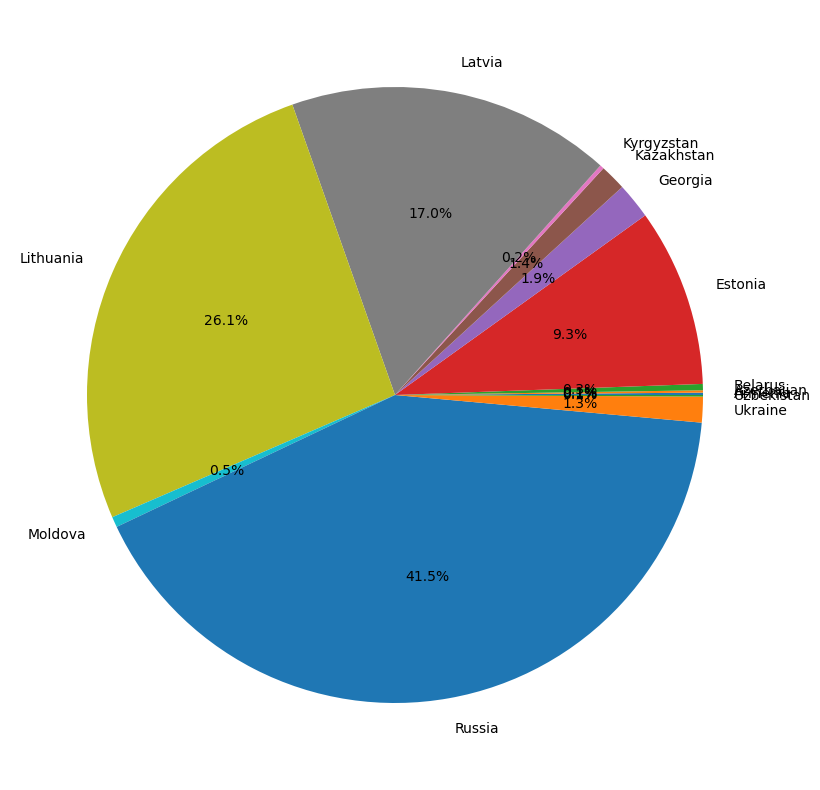

In [4]:
labels = df_soviet["country"]
sizes = df_soviet["total"]

fig, ax = plt.subplots(figsize=(10,10))
ax.pie(sizes, labels=labels, autopct='%1.1f%%');

# Data from the Former USSR countries

## Data from Central Asia, Caucasus (excluding Russia), Moldova, and Ukraine

I used two filters from GISAID databate: Complete and High coverage. I accessed database through its website as I could not find API for it.

In [5]:
# get all file names in Data directory
glob.glob("Data/*")

['Data/Russia_select2000.tsv',
 'Data/Moldova.tsv',
 'Data/Lithuania_all_ids.csv',
 'Data/Armenia.tsv',
 'Data/Russia_all_ids.csv',
 'Data/Lithuania_select2000.fasta',
 'Data/gisaid_monthly_submissions_global_2023-03-28.xlsx',
 'Data/Ukraine.tsv',
 'Data/Uzbekistan.tsv',
 'Data/Belarus.tsv',
 'Data/Moldova.fasta',
 'Data/Georgia.fasta',
 'Data/Estonia_select2000.tsv',
 'Data/Georgia.tsv',
 'Data/Azerbaijan.fasta',
 'Data/Azerbaijan.tsv',
 'Data/Ukraine.fasta',
 'Data/Kyrgyzstan.fasta',
 'Data/Latvia_select2000.tsv',
 'Data/Estonia_all_ids.csv',
 'Data/Uzbekistan.fasta',
 'Data/Kyrgystan.tsv',
 'Data/Belarus.fasta',
 'Data/Kazakhstan.tsv',
 'Data/Kazakhstan.fasta',
 'Data/Estonia_select2000.fasta',
 'Data/Russia_select2000.fasta',
 'Data/Lithuania_select2000.tsv',
 'Data/Armenia.fasta',
 'Data/Latvia_all_ids.csv',
 'Data/Latvia_select2000.fasta']

In [6]:
# create a merged with data from Central Asia, Caucasus (excluding Russia), Moldova, and Ukraine
dfs = []

for filename in glob.glob("Data/*.tsv"):
    pattern = r'/([a-zA-Z]+)\.tsv'
    match = re.search(pattern, filename)
    if match:
        df = pd.read_csv(filename, sep='\t')
        dfs.append(df)
    
merged_df = pd.concat(dfs, ignore_index=True)

merged_df

,Accession ID,Collection date,Submission date,Location
0,EPI_ISL_10512032,2022-01-14,2022-03-01,Europe / Moldova / Chisinau
1,EPI_ISL_10512033,2022-01-08,2022-03-01,Europe / Moldova / Chisinau
2,EPI_ISL_10512036,2021-11-04,2022-03-01,Europe / Moldova / Chisinau
3,EPI_ISL_10512039,2022-01-05,2022-03-01,Europe / Moldova / Chisinau
4,EPI_ISL_10512040,2022-01-08,2022-03-01,Europe / Moldova / Chisinau
...,...,...,...,...
2460,EPI_ISL_8907904,2020-08-10,2022-01-20,Asia / Kazakhstan / Kyzylorda Region / Baikonur
2461,EPI_ISL_8907905,2020-06-25,2022-01-20,Asia / Kazakhstan / Kyzylorda Region / Baikonur
2462,EPI_ISL_8907907,2020-06-26,2022-01-20,Asia / Kazakhstan / Kyzylorda Region / Baikonur
2463,EPI_ISL_8907908,2020-06-26,2022-01-20,Asia / Kazakhstan / Kyzylorda Region / Baikonur


In [7]:
len(merged_df)

2465

In [8]:
list_regions = []
list_countries = []
list_cities = []

for name in merged_df["Location"]:
    tmp = name.split(" / ")
    list_regions.append(tmp[0])
    list_countries.append(tmp[1])        

merged_df["Region"] = list_regions
merged_df["Country"] = list_countries

In [9]:
set(list_countries)

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Moldova',
 'Ukraine',
 'Uzbekistan'}

In [10]:
merged_df

,Accession ID,Collection date,Submission date,Location,Region,Country
0,EPI_ISL_10512032,2022-01-14,2022-03-01,Europe / Moldova / Chisinau,Europe,Moldova
1,EPI_ISL_10512033,2022-01-08,2022-03-01,Europe / Moldova / Chisinau,Europe,Moldova
2,EPI_ISL_10512036,2021-11-04,2022-03-01,Europe / Moldova / Chisinau,Europe,Moldova
3,EPI_ISL_10512039,2022-01-05,2022-03-01,Europe / Moldova / Chisinau,Europe,Moldova
4,EPI_ISL_10512040,2022-01-08,2022-03-01,Europe / Moldova / Chisinau,Europe,Moldova
...,...,...,...,...,...,...
2460,EPI_ISL_8907904,2020-08-10,2022-01-20,Asia / Kazakhstan / Kyzylorda Region / Baikonur,Asia,Kazakhstan
2461,EPI_ISL_8907905,2020-06-25,2022-01-20,Asia / Kazakhstan / Kyzylorda Region / Baikonur,Asia,Kazakhstan
2462,EPI_ISL_8907907,2020-06-26,2022-01-20,Asia / Kazakhstan / Kyzylorda Region / Baikonur,Asia,Kazakhstan
2463,EPI_ISL_8907908,2020-06-26,2022-01-20,Asia / Kazakhstan / Kyzylorda Region / Baikonur,Asia,Kazakhstan


In [11]:
merged_df["Country"].value_counts()

Georgia       708
Kazakhstan    543
Ukraine       527
Azerbaijan    158
Moldova       151
Kyrgyzstan    118
Belarus       114
Armenia        83
Uzbekistan     63
Name: Country, dtype: int64

## Data from the rest of Europe 

It is apparent that the download capacity of GISAID posed a challenge in acquiring a comprehensive dataset for certain countries, such as Russia, Estonia, Latvia and Lithuania. To address this limitation, a decision was made to selectively download data from these countries by randomly selecting 2000 IDs from each. This approach allowed for a representative sample to be obtained, given the available data.

Moreover, the application of filters such as "Complete", "High coverage" and "Complete date" was a prudent step to ensure that the downloaded data adhered to specific quality standards. Such measures helped to mitigate the risk of incorporating incomplete or low-quality data in the analysis.

In [12]:
# all ids are saved in csv files
glob.glob("Data/*.csv")

['Data/Lithuania_all_ids.csv',
 'Data/Russia_all_ids.csv',
 'Data/Estonia_all_ids.csv',
 'Data/Latvia_all_ids.csv']

In [13]:
# create a merged df from all of the mentioned countries
dfs = []

for filename in glob.glob("Data/*.csv"):  
    
    
    df = pd.read_csv(filename, header=None)
    
    # extract name of a country
    pattern = r'/([a-zA-Z]+)_all_ids\.csv'
    country = re.findall(pattern, filename)[0]
    df["Country"] = country
    
    dfs.append(df)
    
ids_df = pd.concat(dfs, ignore_index = True, axis=0)

ids_df.rename(columns={0: "Accession ID"}, inplace=True)

In [14]:
# randomly select IDs from the mentioned in this paragraph countries
# also saves these IDs into csvs
countries = list(ids_df["Country"].unique())

dfs = []

for country in countries:
    df = ids_df[ids_df["Country"] == country].sample(n=2000, random_state=1)
    
    # output a file containing only 2000 ids
    output_name = "Output/" + country + "_ids.csv"
    df["Accession ID"].to_csv(output_name, index=False, index_label=False, header=False)
    dfs.append(df)

ids_df_random2000 = pd.concat(dfs, ignore_index=True)
ids_df_random2000

,Accession ID,Country
0,EPI_ISL_603118,Lithuania
1,EPI_ISL_1960624,Lithuania
2,EPI_ISL_2428325,Lithuania
3,EPI_ISL_8675620,Lithuania
4,EPI_ISL_2082417,Lithuania
...,...,...
7995,EPI_ISL_1613219,Latvia
7996,EPI_ISL_2799075,Latvia
7997,EPI_ISL_1219464,Latvia
7998,EPI_ISL_8385823,Latvia


In [15]:
# create a table with all accession ID used along with countries
all_countries = pd.concat([ids_df_random2000[["Accession ID", "Country"]], merged_df[["Accession ID", "Country"]]], ignore_index=True)
all_countries

,Accession ID,Country
0,EPI_ISL_603118,Lithuania
1,EPI_ISL_1960624,Lithuania
2,EPI_ISL_2428325,Lithuania
3,EPI_ISL_8675620,Lithuania
4,EPI_ISL_2082417,Lithuania
...,...,...
10460,EPI_ISL_8907904,Kazakhstan
10461,EPI_ISL_8907905,Kazakhstan
10462,EPI_ISL_8907907,Kazakhstan
10463,EPI_ISL_8907908,Kazakhstan


In [16]:
all_countries["Country"].value_counts()

Lithuania     2000
Russia        2000
Estonia       2000
Latvia        2000
Georgia        708
Kazakhstan     543
Ukraine        527
Azerbaijan     158
Moldova        151
Kyrgyzstan     118
Belarus        114
Armenia         83
Uzbekistan      63
Name: Country, dtype: int64

In [17]:
all_countries.to_csv("Output/all_countries.csv", index=None)

# Analysis of sequences

i have 10000 seq of dnas from 6 countries. I want to compare countries with each other. I have an idead of using only 20 samples from each country (with bootstraping). Then I calculate individual trees. Then I calculate a consensus tree. Is this a correct approach? Any suggestions?
Your approach of subsampling 20 sequences from each country and performing bootstrap analysis on each subsampled dataset to generate multiple replicate trees, and then constructing a consensus tree from these trees is a valid approach for comparing the phylogenetic relationships among the countries based on the DNA sequences.

## Combine all fasta files

Here, all fasta files with individual countries are merged.

In [18]:
# a list of fasta files
file_list = glob.glob("Data/*.fasta")
file_list

['Data/Lithuania_select2000.fasta',
 'Data/Moldova.fasta',
 'Data/Georgia.fasta',
 'Data/Azerbaijan.fasta',
 'Data/Ukraine.fasta',
 'Data/Kyrgyzstan.fasta',
 'Data/Uzbekistan.fasta',
 'Data/Belarus.fasta',
 'Data/Kazakhstan.fasta',
 'Data/Estonia_select2000.fasta',
 'Data/Russia_select2000.fasta',
 'Data/Armenia.fasta',
 'Data/Latvia_select2000.fasta']

In [26]:
# Assuming the file names are stored in a list called "file_list"
output_file = "Output/combined.fasta"

if os.path.exists(output_file):
    print(f"{output_file} already exists, cannot save CSV file.")
else:
    with open(output_file, "w") as outfile:
        for file in file_list:
            with open(file, "r") as infile:
                outfile.write(infile.read())


Output/combined.fasta already exists, cannot save CSV file.


## Alignment

For alignment the reference genome from Wuhan was used. Alignment was done with nextalign https://docs.nextstrain.org/projects/nextclade/en/stable/user/nextalign-cli.html.

While I can not provide the data itself. However, it can be easily accessed with accession IDs from GISAID. Here is the script that runs alignment. It runs really fast, 30 seconds with 12 threads, and does not consume RAM.

## Sampling function

I have over 10000 records, that is why it is important to limit amount of output.

In [20]:
list_countries = list(all_countries['Country'].unique())
list_countries

['Lithuania',
 'Russia',
 'Estonia',
 'Latvia',
 'Moldova',
 'Armenia',
 'Ukraine',
 'Uzbekistan',
 'Belarus',
 'Georgia',
 'Azerbaijan',
 'Kyrgyzstan',
 'Kazakhstan']

In [72]:
def resample_dnas(database, N=10, bootstrap=False):
    """
    Gets Accesion IDs with bootstraping from each country in equal amounts from a database:
    df = {"Accession ID": IDs, "Country": country}
    
    N - samples, default 20
    bootstrap - True or False (default)
    """
    list_countries = list(database['Country'].unique())
    
    list_IDs = []
    label_countries = []
    
    for country in list_countries:
        df_tmp = all_countries[all_countries['Country']==country].sample(N, replace=bootstrap) 
        list_IDs.extend(list(df_tmp["Accession ID"])) #important to use extend instead of append to generate a flat list, not a nested list
        label_countries.extend([country]*N)# list_countries.extend(df_tmp["Country"])
    
    return list_IDs, label_countries



## Biopython

In [80]:
# select sequences
list_IDs, label_countries = resample_dnas(all_countries)

alignment_file = "Alignment/output/nextalign.aligned.fasta"

i = 0
selected_seq = []

for seq in SeqIO.parse(alignment_file, 'fasta'):
    
    accession_id = seq.id.split(sep='|')[1]
    country = seq.id.split(sep='/')[1]
    
    if accession_id in list_IDs:
        # print(accession_id)
        # print(country)
        i += 1
        selected_seq.append(seq)

# must be the same length if resampling not allowed
print(i)
print(len(selected_seq))

130
130


In [89]:
# construct distance matrix
alignment = MultipleSeqAlignment(selected_seq)

calculator = DistanceCalculator('identity')

# Write the Distance Matrix 
distance_matrix = calculator.get_distance(alignment)

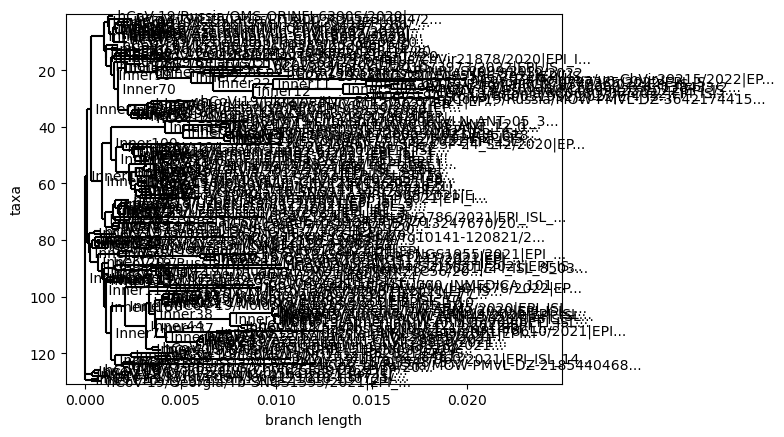

In [91]:
# Open and initiate the Tree Constructor 
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
constructor = DistanceTreeConstructor(calculator)

# Build the tree 
mammals_tree = constructor.build_tree(alignment)
# mammals_tree.rooted = True
# print(mammals_tree)
from Bio import Phylo

fig = Phylo.draw(mammals_tree)
